# Calcula de los DG

Equation 1) in the reference  J. Phys. Chem. B 2014, 118, 11271--11283

ΔG_{solv}^*([Hg(H2O)n]2+) = ΔG_{solv}^*(Hg2+) − ΔG_{g,bind}^* − nΔG_{vap}(H2O)

where ΔG_{solv}^° (Hg(II)) is the solvation free energy of bare Hg2+
which is taken directly from the output of the quantum-chemical program
used, ΔG* g,bind is the gas-phase free energy of the complexation (upper
leg of Scheme 1), and ΔGvap(H2O) is the vaporization free energy of water.
It is defined by

ΔG_{vap}(H2O) = −ΔG_{solv}^*(H2O)-RTln[H2O] − ΔG^{°→*}

where ΔG^*_{solv}(H2O) is again taken directly from the program output.
RTln[H2O] equals 2.38 kcal/mol. ΔG^{°→*} is the free energy change of
1 mol of an ideal gas from 1 atm (24.46 L/mol) to 1 M at T = 298.15 K
and can be defined as

ΔG°→* = −T ΔS^{°→*} = RTln[V_0/V^*] = RTln(24.46) = 1.89 kcal/mo

n es el número de moléculas de agua, G(W) es la energía libre de Gibbs de
la molécula de agua y G(W_i) es energía libre de Gibbs de la molécula de
agua en la geometrias respectivas del agregados en cuestión.

In [1]:
from pathlib import Path
from glob import glob
from itertools import cycle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from natsort import index_natsorted
from brokenaxes import brokenaxes

from ase import Atoms, Atom
from pmutt.io import gaussian
from pmutt.statmech import StatMech, trans, vib, rot, elec
from pmutt.constants import kb, Na


# interactive plots
%matplotlib widget

In [2]:
KB_KCAL: float = kb("kcal/K")
AVOGADRO: float = Na

KB_KCAL_MOL: float = KB_KCAL * AVOGADRO
KB_KCAL_MOL

0.001985875020917578

## Path father of the inputs

In [6]:
working_directory = Path.cwd() / "../structures"

if not working_directory.exists():
    raise ValueError("The working directory does not exist.")

## Inputs files
* ADF.2013 outputs
* .txt with 2 columns: 1) name of the file of the output adf and 2) ADF energies in Ev
* G16 outputs

In [9]:
list_file_adf = glob(str(working_directory) + "/sozora/*.out")
energies_file_adf = working_directory / ("sozora/energies.txt")

if not energies_file_adf.exists():
    raise ValueError("The energies file does not exist.")
if not list_file_adf:
    raise ValueError("The list of ADF files does not exist.")

## Reading coordinates and frequencies from ADF.2013

In [10]:
find_lines_adf = {}
for file_adf in list_file_adf:
    read_file_adf = Path(file_adf).read_text()

    """ Lines to read the geometry and frequencies form ADF.2013 output """
    start_line_geom = None
    last_line_geom = None
    start_line_freq = None
    last_line_freq = None
    for count, line in enumerate(read_file_adf.split("\n")):

        if (
            line
            == "                                            *  F R E Q U E N C I E S  *"
        ):
            start_line_geom = count + 11
        elif line == " Atomic Masses:":
            last_line_geom = count - 3
        elif line == " List of All Frequencies:":
            start_line_freq = count + 9
        elif line == " Statistical Thermal Analysis  ***  ideal gas assumed  ***":
            last_line_freq = count - 4
        elif start_line_geom and last_line_geom and start_line_freq and last_line_freq:
            break

    if not start_line_geom and not last_line_geom and not start_line_freq and not last_line_freq:
        raise ValueError(f"Geometries or frequencies in {file_adf} of ADF.2013 are not.")

    find_lines_adf[Path(file_adf).stem] = [
        start_line_geom,
        last_line_geom,
        start_line_freq,
        last_line_freq,
    ]

if not find_lines_adf:
    raise ValueError("Geometries and frequencies in ADF.2013 does not exist.")

In [11]:
geoms_systems = {}
freqs_systems = {}
energies_systems = {}
for file_adf in list_file_adf:
    with open(Path(file_adf), "r") as f_adf:
        file_content = f_adf.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom = find_lines_adf[Path(file_adf).stem][1]
        start_line_geom = find_lines_adf[Path(file_adf).stem][0]
        lines_geom = last_line_geom - start_line_geom
        coord_system = []
        for i in range(lines_geom):
            line = file_content[start_line_geom + i].split()
            coord_system.append(Atom(line[1], (line[5], line[6], line[7])))
        geoms_systems[Path(file_adf).stem] = Atoms(coord_system)

        """Frequencies"""
        last_line_freq = find_lines_adf[Path(file_adf).stem][3]
        start_line_freq = find_lines_adf[Path(file_adf).stem][2]
        lines_freq = last_line_freq - start_line_freq
        freq_system = []
        for i in range(lines_freq):
            line = file_content[start_line_freq + i].split()
            if float(line[0]) > 20.0:
                freq_system.append(float(line[0]))
        freqs_systems[Path(file_adf).stem] = freq_system

    """Energies from ADF.2013 in Ev"""
    with open(energies_file_adf, "r") as f_energies:
        stop = False
        while stop == False:
            line = f_energies.readline().split()
            if line[0] == Path(file_adf).stem:
                energies_systems[Path(file_adf).stem] = float(line[1])
                stop = True

if not geoms_systems:
    raise ValueError("The geometries of the systems does not exist.")
if not freqs_systems:
    raise ValueError("The frequencies of the systems does not exist.")
if not energies_systems:
    raise ValueError("The energies of the systems does not exist.")

geoms_systems["w1s1"].__dict__

{'_cellobj': Cell([0.0, 0.0, 0.0]),
 '_pbc': array([False, False, False]),
 'arrays': {'numbers': array([80,  8,  1,  1]),
  'positions': array([[-0.244886,  0.095186,  0.      ],
         [ 1.858384, -0.18469 ,  0.      ],
         [ 2.317319,  0.18235 ,  0.80465 ],
         [ 2.317319,  0.18235 , -0.80465 ]])},
 '_celldisp': array([[0.],
        [0.],
        [0.]]),
 '_constraints': [],
 'info': {},
 '_calc': None}

## Build object to statical mechanical calculation

In [12]:
translation = {}
vibration = {}
rotation = {}
electronic = {}
translation_g16 = {}
vibration_g16 = {}
rotation_g16 = {}
electronic_g16 = {}
for count, file_adf in enumerate(list_file_adf):
    name_file = Path(file_adf).stem

    """Translational"""
    translation[name_file] = trans.FreeTrans(
        n_degrees=3, atoms=geoms_systems[name_file]
    )

    """Vibrational"""
    vibration[name_file] = vib.HarmonicVib(
        vib_wavenumbers=freqs_systems[name_file]
    )  # cm^-1

    """Rotational"""
    rotation[name_file] = rot.RigidRotor(
        symmetrynumber=1, atoms=geoms_systems[name_file]
    )  # simmetry point C1

    """Electronic"""
    electronic[name_file] = elec.GroundStateElec(
        potentialenergy=float(energies_systems[name_file]), spin=0
    )  # Ev

if not translation:
    raise ValueError("The translational part of the systems does not exist.")
if not vibration:
    raise ValueError("The vibrational part of the systems does not exist.")
if not rotation:
    raise ValueError("The rotational part of the systems does not exist.")
if not electronic:
    raise ValueError("The electronic part of the systems does not exist.")

## Calculate the partition function

In [13]:
statmech = {}
for file_adf in list_file_adf:
    name_file = Path(file_adf).stem
    """StatMech Initialization ADF.2013"""
    statmech[name_file] = StatMech(
        name=name_file,
        trans_model=translation[name_file],
        vib_model=vibration[name_file],
        rot_model=rotation[name_file],
        elec_model=electronic[name_file],
    )

if not statmech:
    raise ValueError("The statmech does not exist.")

## Thermochemistry quantities

In [14]:
values_T = {
    "systems": [],
    "H[kcal/mol]": [],
    "S[kcal/mol/K]": [],
    "G[kcal/mol]": [],
    "U[kcal/mol]": [],
}
for file_adf in list_file_adf:
    name_file = Path(file_adf).stem
    H_statmech = statmech[name_file].get_H(T=298.15, units="kcal/mol")
    S_statmech = statmech[name_file].get_S(T=298.15, units="kcal/mol/K")
    G_statmech = statmech[name_file].get_G(T=298.15, units="kcal/mol")
    U_statmech = statmech[name_file].get_U(T=298.15, units="kcal/mol")
    values_T["systems"].append(name_file)
    values_T["U[kcal/mol]"].append(U_statmech)
    values_T["S[kcal/mol/K]"].append(S_statmech)
    values_T["H[kcal/mol]"].append(H_statmech)
    values_T["G[kcal/mol]"].append(G_statmech)

pd.DataFrame(values_T).sort_values(by="systems",ascending=True,
    key=lambda x: np.argsort(index_natsorted(values_T["systems"])),
    ).reset_index(drop=True)


,systems,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
0,w1s1,-25267.301616,0.064291,-25286.469943,-25267.894101
1,w2s1,-25668.144242,0.077790,-25691.337472,-25668.736727
2,w3s1,-26028.612760,0.093566,-26056.509399,-26029.205245
3,w3s2,-26016.920429,0.098816,-26046.382560,-26017.512914
4,w3s3,-25993.346695,0.094863,-26021.630140,-25993.939180
5,w4s1,-26380.722574,0.101106,-26410.867402,-26381.315059
6,w4s2,-26376.837751,0.112162,-26410.278856,-26377.430236
7,w4s3,-26370.753345,0.108095,-26402.981940,-26371.345829
8,w4s4,-26361.038428,0.120221,-26396.882235,-26361.630913
9,w5s1,-26722.964409,0.116447,-26757.683222,-26723.556893


## Thermochemistry quantities: different temperatures in kelvin
* ADF.2013
* G16

In [15]:
initital_temperature = 1
final_temperature = 1000
step_temperature = 1

In [16]:
absolute_thermochemistry_per_temperature = {}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    thermo_data = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
        "U[kcal/mol]": [],
    }

    for file_adf in list_file_adf:
        name_file = Path(file_adf).stem

        """ ADF.2013 """
        H_statmech = statmech[name_file].get_H(T=temperature, units="kcal/mol")
        S_statmech = statmech[name_file].get_S(T=temperature, units="kcal/mol/K")
        G_statmech = statmech[name_file].get_G(T=temperature, units="kcal/mol")
        U_statmech = statmech[name_file].get_U(T=temperature, units="kcal/mol")
        thermo_data["system"].append(name_file)
        thermo_data["H[kcal/mol]"].append(H_statmech)
        thermo_data["S[kcal/mol/K]"].append(S_statmech)
        thermo_data["G[kcal/mol]"].append(G_statmech)
        thermo_data["U[kcal/mol]"].append(U_statmech)

        absolute_thermochemistry_per_temperature[temperature] = (
            pd.DataFrame(thermo_data)
            .sort_values(
                by="system",
                ascending=True,
                key=lambda x: np.argsort(index_natsorted(thermo_data["system"])),
            )
            .reset_index(drop=True)
        )

if not absolute_thermochemistry_per_temperature:
    raise ValueError(
        "The absolute thermochemistry or _g16 values of the systems does not exist."
    )

In [17]:
absolute_thermochemistry_per_temperature[298].tail()

,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
34,w6s16,-27045.469767,0.137607,-27086.476737,-27046.061953
35,w6s17,-27042.755489,0.134802,-27082.926498,-27043.347676
36,w6s18,-27037.133691,0.140687,-27079.058346,-27037.725877
37,w6s19,-27031.852986,0.147758,-27075.884895,-27032.445173
38,w6s20,-27031.399499,0.147029,-27075.214018,-27031.991685


# Calculo de Delta

In [23]:
#### water without dielectric
energy_water_molecule = -14.28782550 # Ev
frequencies_water_molecule = [1594.091101, 3703.199734, 3805.951169]#cm^-1
#geometry
water_geometry = [Atom(symbol="O",  position=(0.000000,    0.000000,   -0.167560)),
    Atom(symbol="H",  position=(0.000000,   -0.764129,   -0.763829)),
    Atom(symbol="H",  position=(0.000000,    0.764129,   -0.763829))]

"""Translational"""
w_translation = trans.FreeTrans(
    n_degrees=3, atoms=Atoms(water_geometry)
)
"""Vibrational"""
w_vibration = vib.HarmonicVib(
    vib_wavenumbers=frequencies_water_molecule
)  # cm^-1
"""Rotational"""
w_rotation = rot.RigidRotor(
    symmetrynumber=1, atoms=Atoms(water_geometry)
)  # simmetry point C1
"""Electronic"""
w_electronic = elec.GroundStateElec(
    potentialenergy=float(energy_water_molecule), spin=0
)  # Ev

name_water = "water molecule"
water_statmech = StatMech(
            name="water molecule",
            trans_model=w_translation,
            vib_model=w_vibration,
            rot_model=w_rotation,
            elec_model=w_electronic,
        )

#### water with dielectric (water)
energy_water_molecule_with_dielectric =  -14.55595686 # Ev
frequencies_water_molecule_with_dielectric = [1550.801, 3706.709, 3789.379]#cm^-1
"""Vibrational"""
w_vibration_dielectric = vib.HarmonicVib(
    vib_wavenumbers=frequencies_water_molecule_with_dielectric
)  # cm^-1
"""Electronic"""
w_electronic_dielectric = elec.GroundStateElec(
    potentialenergy=float(energy_water_molecule_with_dielectric), spin=0
)  # Ev

name_water_dielectric = "water molecule with dielectric"
water_statmech_dielectric = StatMech(
            name="water molecule with dielectric",
            trans_model=w_translation,
            vib_model=w_vibration_dielectric,
            rot_model=w_rotation,
            elec_model=w_electronic_dielectric,
        )

In [24]:
print("U[kcal/mol]: ", water_statmech.get_U(T=298.15, units="kcal/mol"))
print("G[kcal/mol]: ", water_statmech.get_G(T=298.15, units="kcal/mol"))

print("\n Dielectric ")
print("U[kcal/mol]: ", water_statmech_dielectric.get_U(T=298.15, units="kcal/mol"))
print("G[kcal/mol]: ", water_statmech_dielectric.get_G(T=298.15, units="kcal/mol"))

U[kcal/mol]:  -314.69181487165434
G[kcal/mol]:  -327.97677397285435

 Dielectric 
U[kcal/mol]:  -320.9552177237175
G[kcal/mol]:  -334.2406535931287


In [25]:
#### Hg without dielectric
energy_hg_molecule = -1077.74307341 # Ev
frequencies_hg_molecule = []#cm^-1
#geometry
hg_geometry = [Atom(symbol="Hg",  position=(0.000000,    0.000000,   0.00000))]

"""Translational"""
hg_translation = trans.FreeTrans(
    n_degrees=3, atoms=Atoms(hg_geometry)
)
"""Vibrational"""
hg_vibration = vib.HarmonicVib(
    vib_wavenumbers=frequencies_hg_molecule
)  # cm^-1
"""Rotational"""
hg_rotation = rot.RigidRotor(
    symmetrynumber=1, atoms=Atoms(hg_geometry)
)  # simmetry point C1
"""Electronic"""
hg_electronic = elec.GroundStateElec(
    potentialenergy=float(energy_hg_molecule), spin=0
)  # Ev

name_hg = "Hg2+ Atom"
hg_statmech = StatMech(
            name="Hg+2 Atom",
            trans_model=hg_translation,
            vib_model=hg_vibration,
            rot_model=hg_rotation,
            elec_model=hg_electronic,
        )

#### hg with dielectric (water)
energy_hg_molecule_with_dielectric = -1091.23545333  # Ev
frequencies_hg_molecule_with_dielectric = []#cm^-1
"""Vibrational"""
hg_vibration_dielectric = vib.HarmonicVib(
    vib_wavenumbers=frequencies_hg_molecule_with_dielectric
)  # cm^-1
"""Electronic"""
hg_electronic_dielectric = elec.GroundStateElec(
    potentialenergy=float(energy_hg_molecule_with_dielectric), spin=0
)  # Ev

name_hg_dielectric = "Hg2+ Atom with Dielectric"
hg_statmech_dielectric = StatMech(
            name="Hg2+ Atom with Dielectric",
            trans_model=hg_translation,
            vib_model=hg_vibration_dielectric,
            rot_model=hg_rotation,
            elec_model=hg_electronic_dielectric,
        )

In [32]:
Path(list_file_adf[0]).stem

'w5s10'

In [76]:
absolute_thermochemistry_per_temperature = {}
R = 0.0019828 #kcal/mol
temperature = 298.15
thermo_data = {
    "system": [],
    "H[kcal/mol]": [],
    "S[kcal/mol/K]": [],
    "G[kcal/mol]": [],
    "U[kcal/mol]": [],
}

H_statmech_hg = hg_statmech.get_H(T=temperature, units="kcal/mol")
S_statmech_hg = hg_statmech.get_S(T=temperature, units="kcal/mol/K")
G_statmech_hg = hg_statmech.get_G(T=temperature, units="kcal/mol")
U_statmech_hg = hg_statmech.get_U(T=temperature, units="kcal/mol")

H_statmech_water = water_statmech.get_H(T=temperature, units="kcal/mol")
S_statmech_water = water_statmech.get_S(T=temperature, units="kcal/mol/K")
G_statmech_water = water_statmech.get_G(T=temperature, units="kcal/mol")
U_statmech_water = water_statmech.get_U(T=temperature, units="kcal/mol")

H_statmech_hg_d = hg_statmech_dielectric.get_H(T=temperature, units="kcal/mol")
S_statmech_hg_d = hg_statmech_dielectric.get_S(T=temperature, units="kcal/mol/K")
G_statmech_hg_d = hg_statmech_dielectric.get_G(T=temperature, units="kcal/mol")
U_statmech_hg_d = hg_statmech_dielectric.get_U(T=temperature, units="kcal/mol")

H_statmech_water_d = water_statmech_dielectric.get_H(T=temperature, units="kcal/mol")
S_statmech_water_d = water_statmech_dielectric.get_S(T=temperature, units="kcal/mol/K")
G_statmech_water_d = water_statmech_dielectric.get_G(T=temperature, units="kcal/mol")
U_statmech_water_d = water_statmech_dielectric.get_U(T=temperature, units="kcal/mol")
for file_adf in list_file_adf:
    name_file = Path(file_adf).stem

    """ ADF.2013 """
    H_statmech_complex = statmech[name_file].get_H(T=temperature, units="kcal/mol")
    S_statmech_complex = statmech[name_file].get_S(T=temperature, units="kcal/mol/K")
    G_statmech_complex = statmech[name_file].get_G(T=temperature, units="kcal/mol")
    U_statmech_complex = statmech[name_file].get_U(T=temperature, units="kcal/mol")


    #
    thermo_data["system"].append(name_file)
    thermo_data["H[kcal/mol]"].append(H_statmech_hg_d - H_statmech_hg - (H_statmech_complex - (H_statmech_hg + int(Path(name_file).stem[1])*H_statmech_water))
                                        + int(Path(name_file).stem[1])*(H_statmech_water_d - H_statmech_water
                                        + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
    thermo_data["S[kcal/mol/K]"].append(S_statmech_hg_d - S_statmech_hg - (S_statmech_complex - (S_statmech_hg + int(Path(name_file).stem[1])*S_statmech_water))
                                        + int(Path(name_file).stem[1])*(S_statmech_water_d - S_statmech_water
                                        + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
    thermo_data["G[kcal/mol]"].append(G_statmech_hg_d - G_statmech_hg - (G_statmech_complex - (G_statmech_hg + int(Path(name_file).stem[1])*G_statmech_water))
                                        + int(Path(name_file).stem[1])*(G_statmech_water_d - G_statmech_water
                                        + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
    thermo_data["U[kcal/mol]"].append(U_statmech_hg_d - U_statmech_hg - (U_statmech_complex - (U_statmech_hg + int(Path(name_file).stem[1])*U_statmech_water))
                                        + int(Path(name_file).stem[1])*(U_statmech_water_d - U_statmech_water
                                        + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))

    absolute_thermochemistry_per_temperature[temperature] = (
        pd.DataFrame(thermo_data)
        .sort_values(
            by="system",
            ascending=True,
            key=lambda x: np.argsort(index_natsorted(thermo_data["system"])),
        )
        .reset_index(drop=True)
    )

if not absolute_thermochemistry_per_temperature:
    raise ValueError(
        "The absolute thermochemistry or _g16 values of the systems does not exist."
    )

In [77]:
absolute_thermochemistry_per_temperature[298.15]

,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
0,w1s1,-211.797590,4.294066,-218.975548,-212.390075
1,w2s1,-127.047706,8.597103,-144.078681,-128.232676
2,w3s1,-82.671931,12.897865,-108.877417,-84.449385
3,w3s2,-94.364262,12.892615,-119.004257,-96.141716
4,w3s3,-117.937996,12.896568,-143.756676,-119.715450
5,w4s1,-46.654859,17.206862,-84.490077,-49.024798
6,w4s2,-50.539682,17.195806,-85.078623,-52.909621
7,w4s3,-56.624089,17.199873,-92.375539,-58.994028
8,w4s4,-66.339005,17.187748,-98.475244,-68.708944
9,w5s1,-20.505767,21.508058,-67.644920,-23.468191


In [75]:
absolute_thermochemistry_per_temperature = {}
R = 0.0019828 #kcal/mol
for temperature in range(initital_temperature, final_temperature, step_temperature):
    thermo_data = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
        "U[kcal/mol]": [],
    }

    H_statmech_hg = hg_statmech.get_H(T=temperature, units="kcal/mol")
    S_statmech_hg = hg_statmech.get_S(T=temperature, units="kcal/mol/K")
    G_statmech_hg = hg_statmech.get_G(T=temperature, units="kcal/mol")
    U_statmech_hg = hg_statmech.get_U(T=temperature, units="kcal/mol")

    H_statmech_water = water_statmech.get_H(T=temperature, units="kcal/mol")
    S_statmech_water = water_statmech.get_S(T=temperature, units="kcal/mol/K")
    G_statmech_water = water_statmech.get_G(T=temperature, units="kcal/mol")
    U_statmech_water = water_statmech.get_U(T=temperature, units="kcal/mol")

    H_statmech_hg_d = hg_statmech_dielectric.get_H(T=temperature, units="kcal/mol")
    S_statmech_hg_d = hg_statmech_dielectric.get_S(T=temperature, units="kcal/mol/K")
    G_statmech_hg_d = hg_statmech_dielectric.get_G(T=temperature, units="kcal/mol")
    U_statmech_hg_d = hg_statmech_dielectric.get_U(T=temperature, units="kcal/mol")

    H_statmech_water_d = water_statmech_dielectric.get_H(T=temperature, units="kcal/mol")
    S_statmech_water_d = water_statmech_dielectric.get_S(T=temperature, units="kcal/mol/K")
    G_statmech_water_d = water_statmech_dielectric.get_G(T=temperature, units="kcal/mol")
    U_statmech_water_d = water_statmech_dielectric.get_U(T=temperature, units="kcal/mol")
    for file_adf in list_file_adf:
        name_file = Path(file_adf).stem

        """ ADF.2013 """
        H_statmech_complex = statmech[name_file].get_H(T=temperature, units="kcal/mol")
        S_statmech_complex = statmech[name_file].get_S(T=temperature, units="kcal/mol/K")
        G_statmech_complex = statmech[name_file].get_G(T=temperature, units="kcal/mol")
        U_statmech_complex = statmech[name_file].get_U(T=temperature, units="kcal/mol")


        #
        thermo_data["system"].append(name_file)
        thermo_data["H[kcal/mol]"].append(H_statmech_hg_d - H_statmech_hg - (H_statmech_complex - (H_statmech_hg + int(Path(name_file).stem[1])*H_statmech_water))
                                            + int(Path(name_file).stem[1])*(H_statmech_water_d - H_statmech_water
                                            + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
        thermo_data["S[kcal/mol/K]"].append(S_statmech_hg_d - S_statmech_hg - (S_statmech_complex - (S_statmech_hg + int(Path(name_file).stem[1])*S_statmech_water))
                                            + int(Path(name_file).stem[1])*(S_statmech_water_d - S_statmech_water
                                            + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
        thermo_data["G[kcal/mol]"].append(G_statmech_hg_d - G_statmech_hg - (G_statmech_complex - (G_statmech_hg + int(Path(name_file).stem[1])*G_statmech_water))
                                            + int(Path(name_file).stem[1])*(G_statmech_water_d - G_statmech_water
                                            + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))
        thermo_data["U[kcal/mol]"].append(U_statmech_hg_d - U_statmech_hg - (U_statmech_complex - (U_statmech_hg + int(Path(name_file).stem[1])*U_statmech_water))
                                            + int(Path(name_file).stem[1])*(U_statmech_water_d - U_statmech_water
                                            + R*temperature*np.log(24.46)+ R*temperature*np.log(56.03)))

        absolute_thermochemistry_per_temperature[temperature] = (
            pd.DataFrame(thermo_data)
            .sort_values(
                by="system",
                ascending=True,
                key=lambda x: np.argsort(index_natsorted(thermo_data["system"])),
            )
            .reset_index(drop=True)
        )

if not absolute_thermochemistry_per_temperature:
    raise ValueError(
        "The absolute thermochemistry or _g16 values of the systems does not exist."
    )

In [67]:
absolute_thermochemistry_per_temperature[298]

,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
0,w1s1,-211.800056,4.291916,-218.974085,-212.392242
1,w2s1,-127.052119,8.592806,-144.074409,-128.236492
2,w3s1,-82.678415,12.891420,-108.870678,-84.454975
3,w3s2,-94.370448,12.886171,-118.998305,-96.147008
4,w3s3,-117.944614,12.890123,-143.750131,-119.721174
5,w4s1,-46.663784,17.198268,-84.479635,-49.032531
6,w4s2,-50.548133,17.187214,-85.069839,-52.916880
7,w4s3,-56.632641,17.191280,-92.366146,-59.001388
8,w4s4,-66.346887,17.179157,-98.467669,-68.715633
9,w5s1,-20.516730,21.497316,-67.631945,-23.477663


In [68]:
max_number_of_waters = 6

dict_relative_population_delta_G = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_G = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        G_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["G[kcal/mol]"]
        )

        G_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["G[kcal/mol]"]

        delta_G = G_values

        total_delta_G = np.exp(-G_values / KB_KCAL_MOL / temperature).sum()

        population_delta_G = (
            np.exp(-G_values / KB_KCAL_MOL / temperature) / total_delta_G
        )

        list_of_delta_G.append(population_delta_G)

    dict_relative_population_delta_G[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_G).T for value in sublist
    ]


df_relative_population_delta_G = pd.DataFrame(dict_relative_population_delta_G)

/home/danian/hg2w/thermo/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/danian/hg2w/thermo/lib/python3.6/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Text(0, 0.5, 'Relative Population $\\Delta$G')

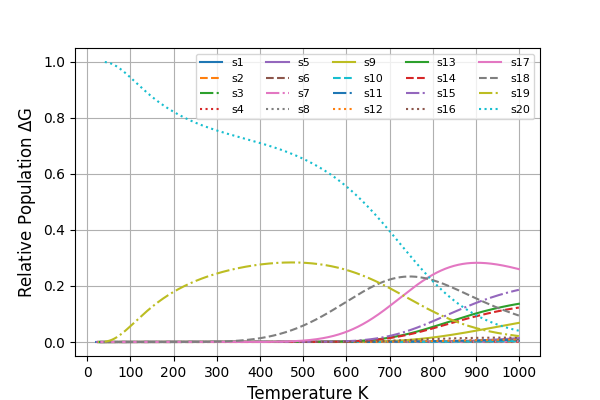

In [69]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)

Text(0, 0.5, 'Relative Population $\\Delta$G')

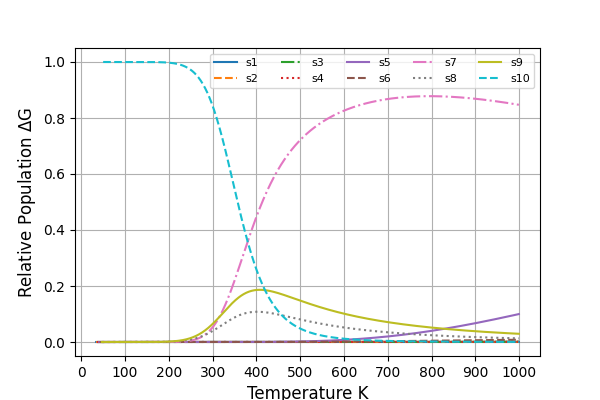

In [70]:
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w5s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)

Text(0, 0.5, 'Relative Population $\\Delta$G')

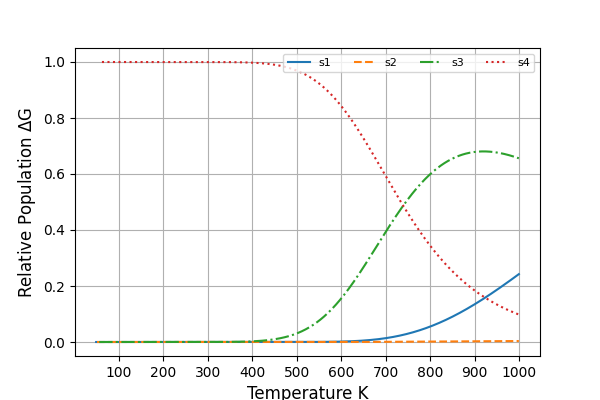

In [71]:
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w4s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)

In [ ]:
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w5s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)

Text(0, 0.5, 'Relative Population $\\Delta$G')

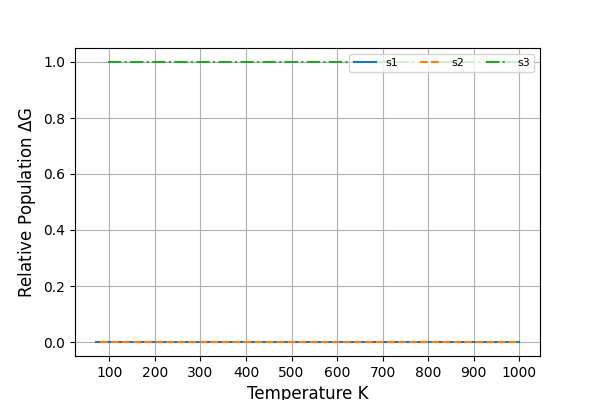

In [72]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]




linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(10, 6))

grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0, 0])
ax1.grid()

ax2 = plt.subplot(grid[0, 1])
ax2.grid()

ax3 = plt.subplot(grid[1, 0])
ax3.grid()

ax4 = plt.subplot(grid[1, 1])
ax4.grid()

# ------------------------------------------------------------------------------
temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax1.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax1.xaxis.set_major_locator(MultipleLocator(100))

# ax1.legend(loc="upper right", fontsize=8, ncol=5)
# ax1.set_xlabel(r"Temperature K", fontsize=12)
ax1.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)
ax1.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax2.plot(
        temp,
        df_relative_population_delta_H[
            df_relative_population_delta_H["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax2.xaxis.set_major_locator(MultipleLocator(100))

# ax2.legend(loc="upper right", fontsize=8, ncol=5)
# ax2.set_xlabel(r"Temperature K", fontsize=12)
ax2.xaxis.set_tick_params(labelsize=8)
ax2.set_ylabel(r"Relative Population $\Delta$H", fontsize=12)
ax2.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax3.plot(
        temp,
        df_relative_population_delta_S[
            df_relative_population_delta_S["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax3.xaxis.set_major_locator(MultipleLocator(100))

# ax3.legend(loc="upper right", fontsize=8, ncol=5)
# ax3.set_xlabel(r"Temperature K", fontsize=12)
ax3.xaxis.set_tick_params(labelsize=8)
ax3.set_ylabel(r"Relative Population $\Delta$S", fontsize=12)
ax3.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax4.plot(
        temp,
        df_relative_population_delta_U[
            df_relative_population_delta_U["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax4.xaxis.set_major_locator(MultipleLocator(100))

# ax4.legend(loc="upper right", fontsize=8, ncol=5)
# ax4.set_xlabel(r"Temperature K", fontsize=12)
ax4.xaxis.set_tick_params(labelsize=8)
ax4.set_ylabel(r"Relative Population $\Delta$U", fontsize=12)
ax4.xaxis.set_tick_params(labelsize=8)

In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w5s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.legend(loc="upper right", fontsize=8, ncol=3)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w4s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))


ax.legend(loc="center left", fontsize=10, ncol=1)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.legend(loc="center left", fontsize=10, ncol=3)
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111)
# ax.grid()

bax = brokenaxes( ylims=((-0.01, 0.07), (0.9, 1.01)), hspace=.2)
bax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    bax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


bax.legend(loc="center left", fontsize=10, ncol=3)
# bax.xaxis.set_major_locator(MultipleLocator(100))
bax.locator_params(nbins=10, axis='y')
bax.locator_params(nbins=20, axis='x')

bax.set_xlabel(r"Temperature K", fontsize=12)
bax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)
